# PyTorch 简介


本笔记本将从 PyTorch 入门开始，PyTorch 是深度学习领域中非常流行的库。
我们将重新实现上一个笔记本中的神经网络，并使用 PyTorch 进行构建。


In [2]:
import random
import numpy as np 
import matplotlib.pyplot as plt

# Import classiques des utilisateurs de pytorch 
import torch 
import torch.nn as nn
import torch.nn.functional as F

### 数据集与数据加载器


我们将以类似上一个笔记本的方式重新构建数据集。此外，需要将输入特征 `X` 和标签 `y` 转换为张量（类似于 micrograd 中的 `Value`）。


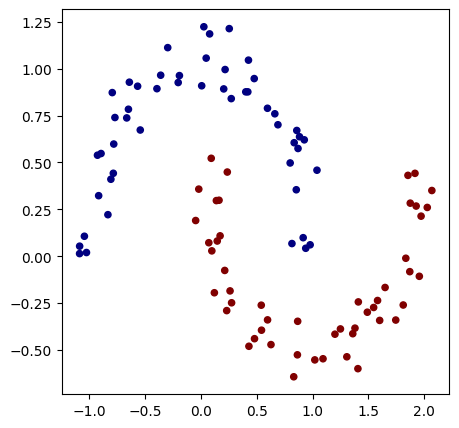

In [5]:
# Initialisation du dataset 
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.1)
X=torch.tensor(X).float() # Conversion en tensor pytorch (équivalent de Value)
y=torch.tensor(y).float() # Conversion en tensor pytorch
y = y*2 - 1 

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

现在，我们将使用 PyTorch 的功能来创建数据集和数据加载器。
数据集仅包含输入特征和标签，而数据加载器通过提供来自数据集的随机小批量数据（数据加载器是一个迭代器），简化了随机梯度下降的使用。


In [6]:
from torch.utils.data import TensorDataset, DataLoader
# Création d'un dataset qui stocke les couples de valeurs X,y
dataset = TensorDataset(X, y)

# Création d'un dataloader qui permet de gérer automatiquement les mini-batchs pour la descente de gradient stochastique. 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

如需了解更多关于数据集和数据加载器的信息，可查阅 [PyTorch 官方文档](https://pytorch.org/docs/stable/index.html)。


### 模型构建


现在，我们构建一个包含 **2 个隐藏层** 的模型。

为此，我们将创建一个继承自 [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) 的 `MLP` 类。
然后，我们使用 [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)（`in_features`, `out_features`）函数构建网络的各层，
该函数会创建一个全连接层，其输入维度为 `in_features`，输出维度为 `out_features`。
这一层由 `out_features` 个神经元组成，每个神经元与 `in_features` 个输入相连。


In [7]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(2,16) # première couche cachée 
    self.fc2=nn.Linear(16,16) # seconde couche cachée 
    self.fc3=nn.Linear(16,1) # couche de sortie
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [8]:
model = mlp() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Nombre de paramètres 337


该模型的参数数量与之前使用 micrograd 时的模型一致。


### 损失函数


PyTorch 已经内置了一些常用的损失函数。在实现自定义损失函数之前，请先检查是否已存在。

这里，我们将使用 PyTorch 的 `torch.nn.MSELoss` 函数，其定义为：
$MSE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
其中，$y_i$ 是真实值（标签），$\hat{y}_i$ 是预测值，$n$ 是小批量数据中的样本总数。

在 PyTorch 中，该损失函数的实现非常简便：


In [10]:
criterion=torch.nn.MSELoss()

### 模型训练


在训练过程中，我们需要定义 **超参数** 和 **优化器**。
[优化器](https://pytorch.org/docs/stable/optim.html) 是 PyTorch 中的一个类，用于指定训练过程中权重的更新方法（包括模型权重更新和学习率设置）。
常见的优化器包括：SGD、Adam、Adagrad、RMSProp 等。
这里我们使用 **SGD**（随机梯度下降）以复现上一个笔记本的训练条件，但在实际应用中，通常更推荐使用 **Adam**（自适应矩估计）。
如需了解优化器的更多细节及其差异，可参考优化器的加餐课程、[PyTorch 官方文档](https://pytorch.org/docs/stable/optim.html) 或 [此博客文章](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/)。


In [11]:
# Hyper-paramètres
epochs = 100 # Nombre de fois où l'on parcoure l'ensemble des données d'entraînement
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


我们还可以使用 **学习率调度器**（scheduler），在训练过程中动态调整学习率，以加速模型收敛（例如，从较高的学习率开始，逐渐降低）。
为了实现训练过程中学习率逐渐减小（如 micrograd 示例中所示），可以使用 [LinearLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html#linearlr)。
如需了解不同类型的调度器，可查阅 [PyTorch 官方文档](https://pytorch.org/docs/stable/optim.html)。


In [12]:
scheduler=torch.optim.lr_scheduler.LinearLR(optimizer=optimizer,start_factor=1,end_factor=0.05)

In [14]:
for i in range(epochs):
  loss_epoch=0
  accuracy=[]
  for batch_X, batch_y in dataloader:
    scores=model(batch_X)        
    loss=criterion(scores,batch_y.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step() # Pour activer le scheduler  
    loss_epoch+=loss
    
    accuracy += [(label > 0) == (scorei.data > 0) for label, scorei in zip(batch_y, scores)]
  accuracy=sum(accuracy) / len(accuracy) 
  
  if i % 10 == 0:
    print(f"step {i} loss {loss_epoch}, précision {accuracy*100}%")

step 0 loss 0.12318143993616104, précision tensor([100.])%
step 10 loss 0.1347985863685608, précision tensor([100.])%
step 20 loss 0.10458286106586456, précision tensor([100.])%
step 30 loss 0.14222581684589386, précision tensor([100.])%
step 40 loss 0.1081438660621643, précision tensor([100.])%
step 50 loss 0.10838648676872253, précision tensor([100.])%
step 60 loss 0.09485019743442535, précision tensor([100.])%
step 70 loss 0.07788567245006561, précision tensor([100.])%
step 80 loss 0.10796503722667694, précision tensor([100.])%
step 90 loss 0.07869727909564972, précision tensor([100.])%


训练速度明显更快！

我们可以将训练结果可视化：


(-1.6418534517288208, 2.108146548271179)

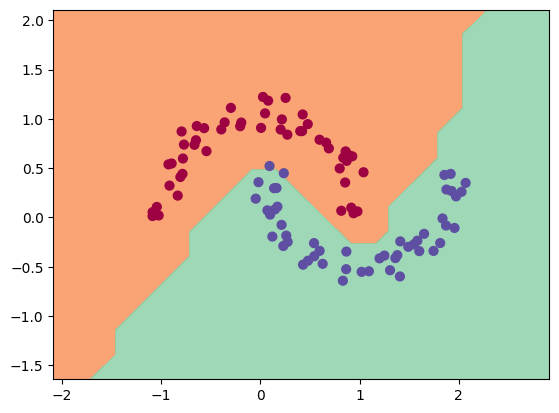

In [15]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs=torch.tensor(Xmesh).float()
scores=model(inputs)

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

如图所示，训练过程顺利进行，并且模型对数据的分类效果良好。
